In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
# from google.colab import drive

# drive.mount('/content/gdrive/')
# root_path = 'gdrive/My Drive/DA-1/'
root_path = ''

data = pd.read_csv(root_path+"Indian Earthquakes List Update_Magnitudes.csv", low_memory=False)
data = data.drop(['REFERENCE'],axis =1)
data = data.drop(['Sl. No.'],axis =1)
data = data.drop(['Mb'],axis =1)
data = data.drop(['Ms'],axis =1)
data = data.drop(['Ml'],axis =1)
data = data[data['Mw'].notna()]


In [2]:
# Gotta convert intensity values to integers
# data.INTENSITY.unique()
data['INTENSITY']=data['INTENSITY'].str.replace('X', '10')
data['INTENSITY']=data['INTENSITY'].str.replace('IV', '4')
data['INTENSITY']=data['INTENSITY'].str.replace('VIII', '8')
data['INTENSITY']=data['INTENSITY'].str.replace('VII', '7')
data['INTENSITY']=data['INTENSITY'].str.replace('VI', '6')
data['INTENSITY']=data['INTENSITY'].str.replace('V', '5')
data.INTENSITY.unique()

array([nan, '10', '5', '7', '6', '8'], dtype=object)

In [3]:
# Pick a threshold that seem fit between [4, 5] inclusive.
# For Mw < T , label becomes 0 (no earthquake) and for Mw ≥ T becomes 1 (earthquake)
T = 4.5

In [4]:
# Convert values of Mw according to T for labels
data['label'] = data['Mw'].astype(str)
data['label']=pd.to_numeric(data['label'], downcast='float', errors='coerce')
data['label'] = (data['label'] >= T).astype(int)
data.columns = ['YEAR','MONTH', 'DATE', 'ORIGIN', 'Mw', 'LAT', 'LONG', 'DEPTH', 'INTENSITY', 'LOCATION', 'label']
data.head()

,YEAR,MONTH,DATE,ORIGIN,Mw,LAT,LONG,DEPTH,INTENSITY,LOCATION,label
0,-2474,0,0.0,NaN,7.5,71.0,24.00,0.0,NaN,NaN,1
1,-325,0,0.0,NaN,7.5,71.0,24.00,0.0,NaN,NaN,1
2,25,0,0.0,NaN,7.5,72.9,33.72,0.0,NaN,NaN,1
3,26,5,10.0,08.19.10.0,6.1397,17.3,80.10,NaN,NaN,NaN,1
4,26,5,10.0,08.19.10.0,6.1397,26.0,97.00,80.0,NaN,Myanmar,1


In [46]:
data['Mw']=pd.to_numeric(data['Mw'], downcast='float', errors='coerce')
data['DATE']=pd.to_numeric(data['DATE'], downcast='float', errors='coerce')
data['MONTH']=pd.to_numeric(data['MONTH'], downcast='float', errors='coerce')

In [6]:
data.shape[0]


50485

In [7]:
# Cleaning
outliers = data.isnull().sum()
print("Missing values: ")
print(outliers[outliers>0])

Missing values: 
MONTH           10
DATE            11
ORIGIN       31232
DEPTH         1257
INTENSITY    50472
LOCATION     41631
dtype: int64


In [48]:
data.Mw.median()
data.Mw.mean()

4.577815055847168

In [15]:
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# train, test = train_test_split(data, test_size=0.2)
features = ['DATE','MONTH','YEAR','LAT', 'LONG', 'DEPTH']
# features = ['DEPTH', 'INTENSITY']
X = data[features]
y=data.label
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=1)

In [16]:
# Missing Values
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(train_X))
imputed_X_valid = pd.DataFrame(my_imputer.transform(val_X))

In [17]:
dec_model=DecisionTreeRegressor(random_state=1)
dec_model.fit(imputed_X_train, train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [18]:
from sklearn.metrics import mean_absolute_error

val_predictions = dec_model.predict(imputed_X_valid)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))
print(val_mae)

Validation MAE when not specifying max_leaf_nodes: 0
0.36495988907596316


In [19]:
dec_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)
dec_model.fit(imputed_X_train, train_y)
val_predictions = dec_model.predict(imputed_X_valid)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.0f}".format(val_mae))
print(val_mae)

Validation MAE for best value of max_leaf_nodes: 0
0.38440047094914936


100
120
140
160
180
200
220
240
260
280
300
320


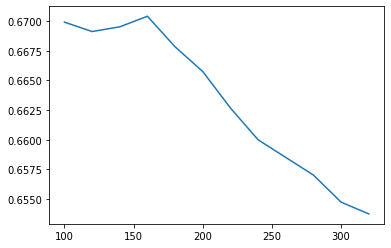

In [41]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(imputed_X_train)
val_X_scaled = scaler.transform(imputed_X_valid)
knn_scores = []
for k in range(100,int(np.sqrt(data.shape[0]))+100,20):
    print(k)
    # knn = KNeighborsClassifier(n_neighbors=3)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_X_scaled, train_y)
    knn_pred = knn.predict(val_X_scaled)
    knn_scores.append(accuracy_score(val_y, knn_pred))

plt.plot(range(100,int(np.sqrt(data.shape[0]))+100,20),knn_scores)

26
27
28


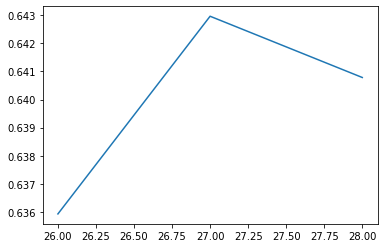

In [38]:

tree_scores = []
for d in [26,27,28]:
    print(d)
    # tree = DecisionTreeClassifier(max_depth=5, random_state=17)
    tree = DecisionTreeClassifier(max_depth=d, random_state=17)
    tree.fit(imputed_X_train, train_y)    
    tree_pred = tree.predict(imputed_X_valid)
    tree_scores.append(accuracy_score(val_y, tree_pred))

plt.plot(np.arange(26,29),tree_scores)

          0     1       2       3       4      5         6
0      19.0   2.0  1994.0   9.780  94.060   33.0  6.277778
1      21.0   2.0  2001.0  72.820  39.850    0.0  6.277778
2      18.0   5.0  2007.0  95.920   4.560   30.0  6.277778
3      18.0   4.0  2002.0  10.070  92.870   33.0  6.277778
4      22.0   1.0  2003.0  86.940  28.310   87.1  6.277778
...     ...   ...     ...     ...     ...    ...       ...
42386   3.0  11.0  2008.0  71.370  36.440  138.0  6.277778
42387  24.0   9.0  2003.0  35.520  74.650   33.0  6.277778
42388  16.0   7.0  1973.0  25.022  95.083  121.5  6.277778
42389  23.0   2.0  1985.0  72.100  37.690   59.0  6.277778
42390  15.0   3.0  2003.0  77.710  39.250   10.0  6.277778

[42391 rows x 7 columns]


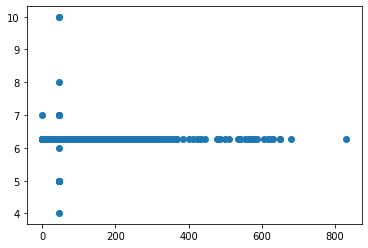

In [99]:
print(imputed_X_train)
plt.scatter(imputed_X_train[5],imputed_X_train[6])

0.6531421022834497

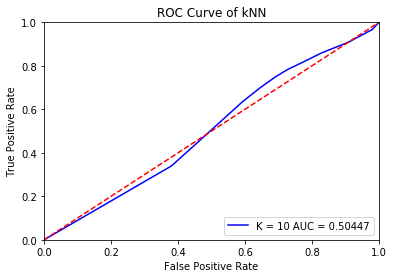

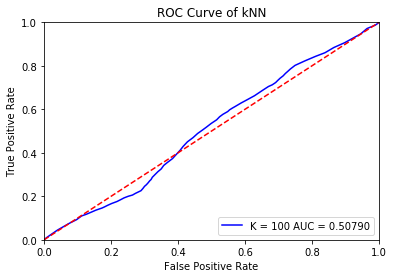

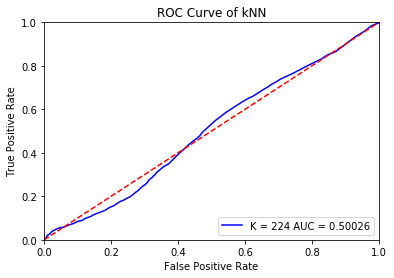

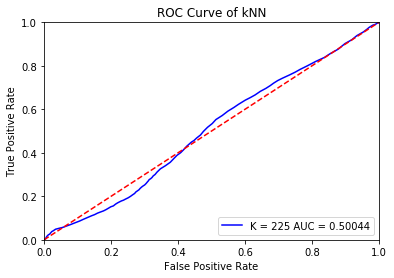

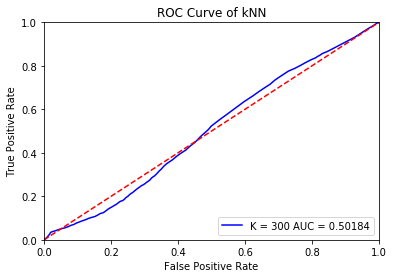

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# ROC with K as parameter in KNN
# knn = KNeighborsClassifier(n_neighbors = 10)
for k in [10,100,224,225,300]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_X_scaled, train_y)

    y_scores = knn.predict_proba(imputed_X_valid)

    fpr, tpr, threshold = roc_curve(val_y, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.title('KNN Classifier on Indian Earthquakes')
    plt.plot(fpr, tpr, 'b', label = 'K = %d AUC = %0.5f' % (k,roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of kNN')
    plt.show()

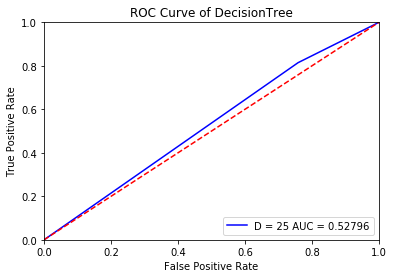

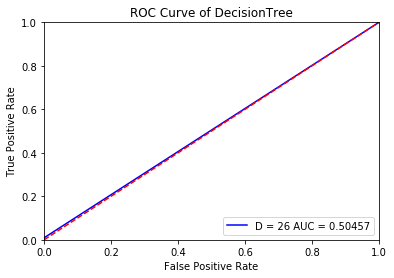

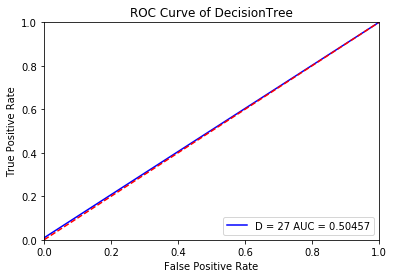

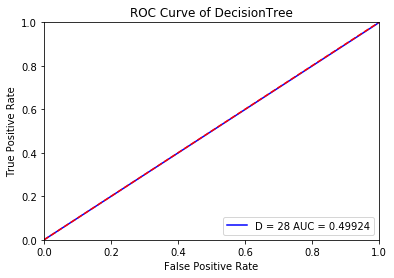

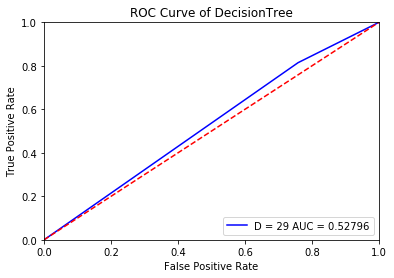

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# ROC with K as parameter in KNN
# knn = KNeighborsClassifier(n_neighbors = 10)
for d in range(25,30):
    tree = DecisionTreeClassifier(max_depth=d)
    tree.fit(train_X_scaled, train_y)

    y_scores = tree.predict_proba(imputed_X_valid)

    fpr, tpr, threshold = roc_curve(val_y, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.title('DecisionTree Classifier on Indian Earthquakes')
    plt.plot(fpr, tpr, 'b', label = 'D = %d AUC = %0.5f' % (d,roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of DecisionTree')
    plt.show()

In [66]:
from sklearn.tree.export import export_text
tree_rules = export_text(tree, feature_names=features)
print(tree_rules)

|--- YEAR <= 1995.50
|   |--- DEPTH <= 32.95
|   |   |--- YEAR <= 1977.50
|   |   |   |--- LAT <= 31.78
|   |   |   |   |--- YEAR <= 1969.50
|   |   |   |   |   |--- LAT <= 25.99
|   |   |   |   |   |   |--- LONG <= 99.04
|   |   |   |   |   |   |   |--- LAT <= 24.24
|   |   |   |   |   |   |   |   |--- LONG <= 70.26
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- LONG >  70.26
|   |   |   |   |   |   |   |   |   |--- LAT <= 23.86
|   |   |   |   |   |   |   |   |   |   |--- LAT <= 22.96
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- LAT >  22.96
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- LAT >  23.86
|   |   |   |   |   |   |   |   |   |   |--- LAT <= 24.07
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- LAT >  24.07
|   |   |   |   |   |   |   

In [ ]:
data['NEW_FEATURE'] = 5*data['YEAR']+